In [1]:
library(tidyverse)
library(cowplot)
library(gridExtra)


`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



# 1. Subfigure A

Differences in overall degree distributions for networks of the same kind of data

In [2]:
ppi_df <- read_tsv('../../data/task3/3.all_nodes/ppi.tsv.xz') %>%
    select(-starts_with('name')) %>%
    gather('id_side', 'id', id_a:id_b) %>%
    group_by(.dots=c("id")) %>%
    summarize_at(vars(train, test_new), funs(sum)) %>%
    rename(biased=train, unbiased=test_new) %>%
    gather('network_type', 'degree', biased:unbiased) %>%
    mutate(name = 'ppi')

tftg_df <- read_tsv('../../data/task3/3.all_nodes/tftg.tsv.xz') %>%
    select(-starts_with('name')) %>%
    gather('id_side', 'id', id_a:id_b) %>%
    group_by(.dots=c("id_side", "id")) %>%
    summarize_at(vars(train, test_new), funs(sum)) %>%
    rename(biased=train, unbiased=test_new) %>%
    gather('network_type', 'degree', biased:unbiased) %>%
    mutate(name = id_side %>% recode(id_a = 'tftg_source', id_b = 'tftg_target')) %>%
    ungroup() %>%
    select(-id_side)

biorxiv_df <- read_tsv('../../data/task3/3.all_nodes/biorxiv.tsv.xz') %>%
    select(-starts_with('name')) %>%
    gather('id_side', 'id', id_a:id_b) %>%
    group_by(.dots=c("id")) %>%
    summarize_at(vars(train, test_new), funs(sum)) %>%
    rename(biased=train, unbiased=test_new) %>%
    gather('network_type', 'degree', biased:unbiased) %>%
    mutate(
        name = 'co_author',
        network_type = network_type %>% recode(biased = "<2018", unbiased = ">=2018")
    )

histogram_vis_df <- bind_rows(ppi_df, tftg_df, biorxiv_df) %>%
    mutate(
        name = name %>% recode_factor(
            ppi = 'PPI', 
            tftg_source = 'TF-TG: TF', 
            tftg_target = 'TF-TG: TG',
            co_author = 'Co-authorship',
        ),
        network_type = network_type %>% recode_factor(
            biased = 'Literature-derived',
            unbiased = 'Systematic',
        )
    )

head(histogram_vis_df, 2)

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)
Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session.”Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)
Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double()

id,network_type,degree,name
<dbl>,<fct>,<dbl>,<fct>
0,Literature-derived,55,PPI
1,Literature-derived,3,PPI


In [3]:
histogram_labels <- data.frame(
    name = c('PPI', 'PPI', 'TF-TG: TF', 'TF-TG: TF', 'TF-TG: TG', 'TF-TG: TG', 
             'Co-authorship', 'Co-authorship'),
    x = c(250, 50, 50, 300, 8, 25, 15, 25),
    y = c(550, 2000, 40, 12, 500, 200, 1500, 500),
    label = factor(c('Literature-derived', 'Systematic', 
              'Literature-derived', 'Systematic', 
              'Literature-derived', 'Systematic', 
              '<2018', '>=2018'), levels = c('Systematic', 'Literature-derived', '<2018', '>=2018')),
    network_type = factor(c('Literature-derived', 'Systematic', 
                     'Literature-derived', 'Systematic', 
                     'Literature-derived', 'Systematic', 
                     '<2018', '>=2018'), levels = c('Literature-derived', 'Systematic', '<2018', '>=2018'))
)

histogram_dists <- (
    ggplot(histogram_vis_df, aes(x = degree, fill = network_type))
    + geom_histogram(position = position_identity(), alpha = 0.5, bins = 50)
    + facet_wrap("name", scales = 'free', nrow = 2)
    + scale_fill_brewer(palette = "Set1")
    + scale_color_brewer(palette = "Set1")
    + ylab('Nodes')
    + xlab('Node degree')
    + theme_zietzm()
    + labs(fill = 'Network type')
    + theme(legend.position = "none")
    + geom_text(data = histogram_labels, aes(x = x, y = y, label = label, color = network_type), 
                alpha = 0.8, size = 4, nudge_x = -5, hjust = 'left')
)

# 2. Subfigures B and C

Differences in node degree by sampling method

In [4]:
format_degrees <- function(df) {
    # Helper function to compute degree
    df %>%
        group_by(id_a) %>%
        summarise(
            degree_a_train = sum(train),
            degree_a_test_recon = sum(test_recon),
            degree_a_test_new = sum(test_new)
        ) %>%
        full_join(
            df %>%
            group_by(id_b) %>%
            summarise(
                degree_b_train = sum(train),
                degree_b_test_recon = sum(test_recon),
                degree_b_test_new = sum(test_new)
            ),
            by = c("id_a" = "id_b")
        ) %>%
        replace(is.na(.), 0) %>%
        mutate(
            degree_train = degree_a_train + degree_b_train,
            degree_test_recon = degree_a_test_recon + degree_b_test_recon,
            degree_test_new = degree_a_test_new + degree_b_test_new
        ) %>%
        select(degree_train, degree_test_recon, degree_test_new)
}

In [5]:
ppi_df <- read_tsv('../../data/task3/2.edges//ppi.tsv.xz')
tftg_df <- read_tsv('../../data/task3/2.edges//tftg.tsv.xz')

head(ppi_df, 2)

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)
Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)


name_a,name_b,id_a,id_b,train,test_recon,test_new
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A0A087WT00,O00154,0,48,1,1,0
A0A087WT00,O43736,0,237,0,1,0


In [6]:
df <- bind_rows(
    ppi_df %>% 
        format_degrees %>%
        mutate(network = 'PPI'),
    tftg_df %>%
        format_degrees %>%
        mutate(network = 'TF-TG')
)

vis_df <- bind_rows(
        df %>%
            select(x = degree_test_recon, y = degree_train, network) %>%
            mutate(task = 'Reconstruction'), 
        df %>%
            select(x = degree_test_recon, y = degree_test_new, network) %>%
            mutate(task = 'Systematic')
    ) %>%
    mutate(task = task %>% recode_factor(Reconstruction = 'Subsampled holdout',
                                         Systematic = 'Systematic holdout'))

In [7]:
palette <- 'Spectral'
direction <- -1

degree_bias <- (
    ggplot(vis_df, aes(x = x + 1, y = y + 1))
    + stat_binhex(aes(color = ..count..), bins = 15)
    + geom_abline(slope = 1, intercept = 0, color = 'black', linetype = 'dashed')
    + xlab('Literature degree')
    + ylab('Holdout degree')
    + facet_grid(rows = vars(network), cols = vars(task))
    + scale_x_log10()
    + scale_y_log10()
    + theme_zietzm()
    + scale_fill_distiller(palette = palette, direction = direction, name = 'Node pairs')
    + scale_color_distiller(palette = palette, direction = direction, name = 'Node pairs')
    + coord_fixed(xlim = c(1, 1000), ylim = c(1, 1000), ratio = 1)
    + theme(legend.position = c(0.875, 0.08), 
            legend.background = element_rect(fill = NA, colour = NA),
            legend.direction = 'horizontal',
            legend.text = element_text(size = 7),
            legend.key.size = unit(0.35, "cm"),
            legend.title = element_text(size = 9),
            legend.title.align = 0.5,
    )
    + guides(fill = guide_colorbar(title.position = 'top'),
             color = guide_colorbar(title.position = 'top'))
)

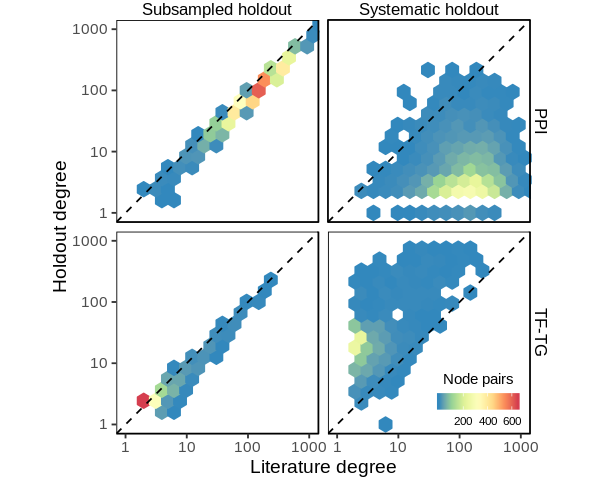

In [8]:
options(repr.plot.width=5, repr.plot.height=4)

degree_bias

# 3. Subfigure D 

Degree distributions of some networks within Hetionet

In [9]:
hetionet_degree <- read_tsv('../../data/task1/hetionet_degrees.tsv')

hetionet_degree %>% head

Parsed with column specification:
cols(
  degree = col_double(),
  metaedge = col_character(),
  side = col_character(),
  square = col_logical()
)


degree,metaedge,side,square
<dbl>,<chr>,<chr>,<lgl>
7,AlD,source,FALSE
9,AlD,source,FALSE
6,AlD,source,FALSE
10,AlD,source,FALSE
9,AlD,source,FALSE
16,AlD,source,FALSE


In [10]:
hetionet_degree_plot <- hetionet_degree %>%
filter(str_detect(string = metaedge, pattern = 'CrC|AuG|AeG|G<rG|DaG|DdG')) %>%
unite('metaedge_side', c('metaedge', 'side'), remove = F) %>%
filter(!str_detect(string = metaedge_side, pattern = 'AeG_target|DaG_source|AuG_target|DdG_target')) %>%
mutate(
    metaedge_side = metaedge_side %>% recode_factor(
        AeG_source = 'Anatomy→\nexpresses→\nGene',
        AuG_source = 'Anatomy→\nupregulates→\nGene',
        CrC_square = 'Compound-\nresembles-\nCompound',
        DaG_target = 'Disease→\nassociates→\nGene',
        DdG_source = 'Disease→\nregulates→\nGene',
        'G<rG_source' = 'Gene→\nregulates→\nGene',
        'G<rG_target' = 'Gene←\nregulates←\nGene'
    )
) %>%
ggplot(aes(y = degree, x = metaedge_side)) +
geom_violin(scale = "width", fill = 'grey85') +
scale_y_log10() +
xlab('Network') +
ylab('Node degree') +
theme_zietzm()

# 4. Subfigure E

Correlation between features and degree product

In [11]:
full_features <- read_tsv('../../data/task3/4.data/ppi.tsv.xz')
features_df <- read_csv('../../data/prediction_features.csv.xz')

degrees_df <- full_features %>%
    filter(network == 'test_recon') %>%
    select(id_a, id_b, edge) %>%
    group_by(id_a) %>%
    mutate(source_degree = sum(edge)) %>%
    ungroup() %>%
    group_by(id_b) %>%
    mutate(target_degree = sum(edge)) %>%
    ungroup() %>%
    select(-edge) %>%
    filter(id_a == id_b) %>%
    mutate(degree = source_degree + target_degree) %>%
    select(id = id_a, degree)

feature_degree_df <- full_features %>%
    filter(network == 'test_recon') %>%
    select(id_a, id_b, edge, edge_prior, rwr, jaccard) %>%
    left_join(features_df, by = c("id_a", "id_b")) %>%
    select(-source, -target) %>%
    left_join(degrees_df, by = c("id_a" = "id")) %>%
    left_join(degrees_df, by = c("id_b" = "id")) %>%
    mutate(degree_product = degree.x * degree.y) %>%
    filter(edge == 0 & id_a != id_b) %>%
    sample_n(10000) %>%
    gather('feature', 'value', rwr, jaccard, adamic_adar_index, preferential_attachment, 
           resource_allocation_index) %>%

    mutate(
        feature = feature %>% recode_factor(adamic_adar_index = 'Adamic/Adar index', 
                                            jaccard = 'Jaccard index',
                                            preferential_attachment = 'Preferential attachment\nindex',
                                            resource_allocation_index = 'Resource allocation\nindex',
                                            rwr = 'Random walk\nwith restart',
        )
    )

# Dataframe for annotating correlations onto the facets
correlations <- feature_degree_df %>% 
    group_by(feature) %>%
    summarize(r = cor(degree_product, value, method = 'pearson')) %>%
    mutate(r = r %>% sprintf(fmt = 'r = %.1f'))

Parsed with column specification:
cols(
  id_a = col_double(),
  id_b = col_double(),
  network = col_character(),
  edge = col_double(),
  edge_prior = col_double(),
  rwr = col_double(),
  mean_rwr = col_double(),
  p_rwr = col_double(),
  jaccard = col_double(),
  mean_jaccard = col_double(),
  p_jaccard = col_double()
)
Parsed with column specification:
cols(
  id_a = col_double(),
  id_b = col_double(),
  adamic_adar_index = col_double(),
  preferential_attachment = col_double(),
  resource_allocation_index = col_double(),
  source = col_double(),
  target = col_double()
)


In [12]:
feature_degree <- feature_degree_df %>%
    ggplot(aes(x = degree_product, y = value)) +
    geom_point(alpha = 0.3) +
    facet_wrap(vars(feature), scales = 'free', nrow = 1) +
    xlab('Product of source and target degree') +
    ylab('Feature value') +
    theme_zietzm() +
    theme(axis.text = element_blank()) +
    geom_text(data = correlations, aes(x = Inf, y = -Inf, label = r), vjust = -0.75, hjust = 1.1)

# 5. Save figures

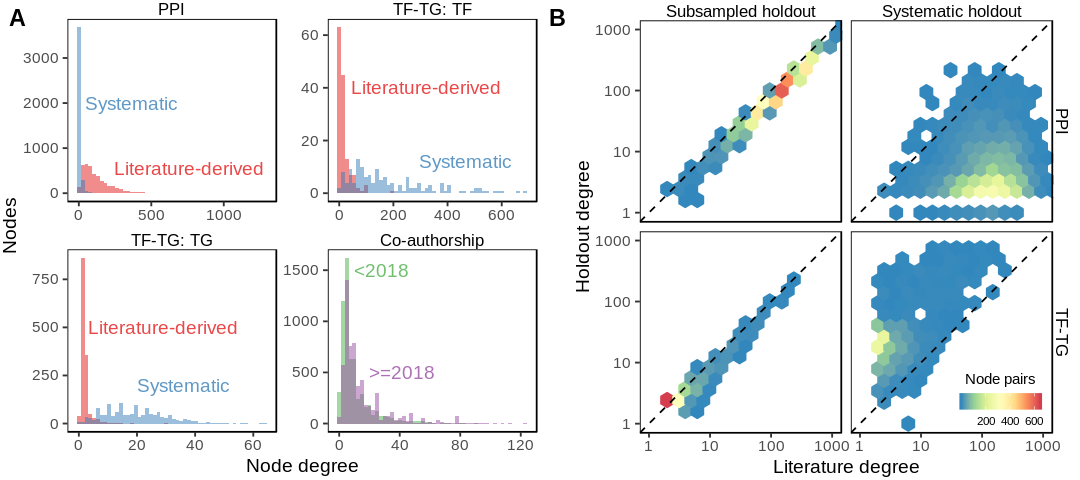

In [13]:
options(repr.plot.width=9, repr.plot.height=4)

combined <- plot_grid(
    histogram_dists, 
    degree_bias + theme(plot.margin = unit(c(0.1, -1, 0.05, -0.5), 'cm')), 
    labels = c("A", "B")
)

ggsave('../../img/degree_bias.png', combined, width = 9, height = 4, dpi = 400)

combined

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 46652 rows containing non-finite values (stat_ydensity).”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 46652 rows containing non-finite values (stat_ydensity).”

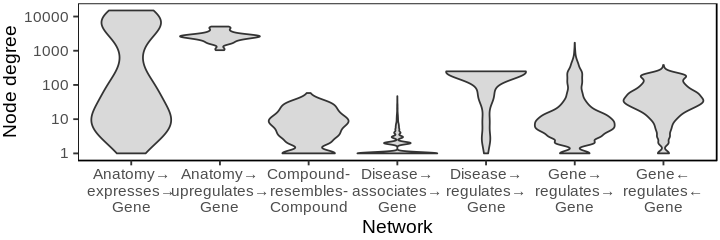

In [14]:
options(repr.plot.width=6, repr.plot.height=2)

ggsave('../../img/hetionet_degrees.png', hetionet_degree_plot, width = 6, height = 2, dpi = 400)

hetionet_degree_plot

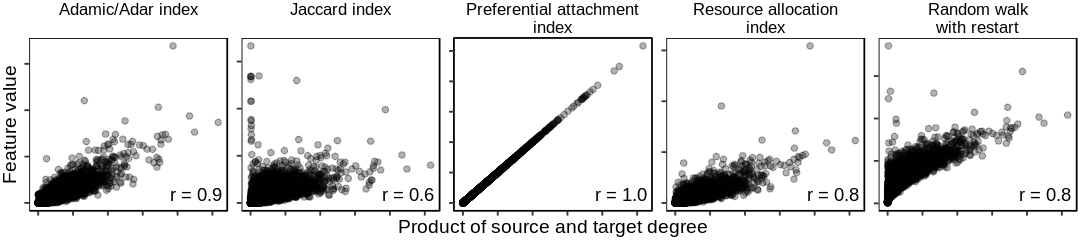

In [15]:
options(repr.plot.width=9, repr.plot.height=2)

ggsave('../../img/feature_degree.png', feature_degree, width = 9, height = 2, dpi = 400)

feature_degree